PROYECTO: PÉNDULO AMORTIGUADO Y FORZADO - ANÁLISIS DE CAOS

1. Comparando diferentes regímenes...


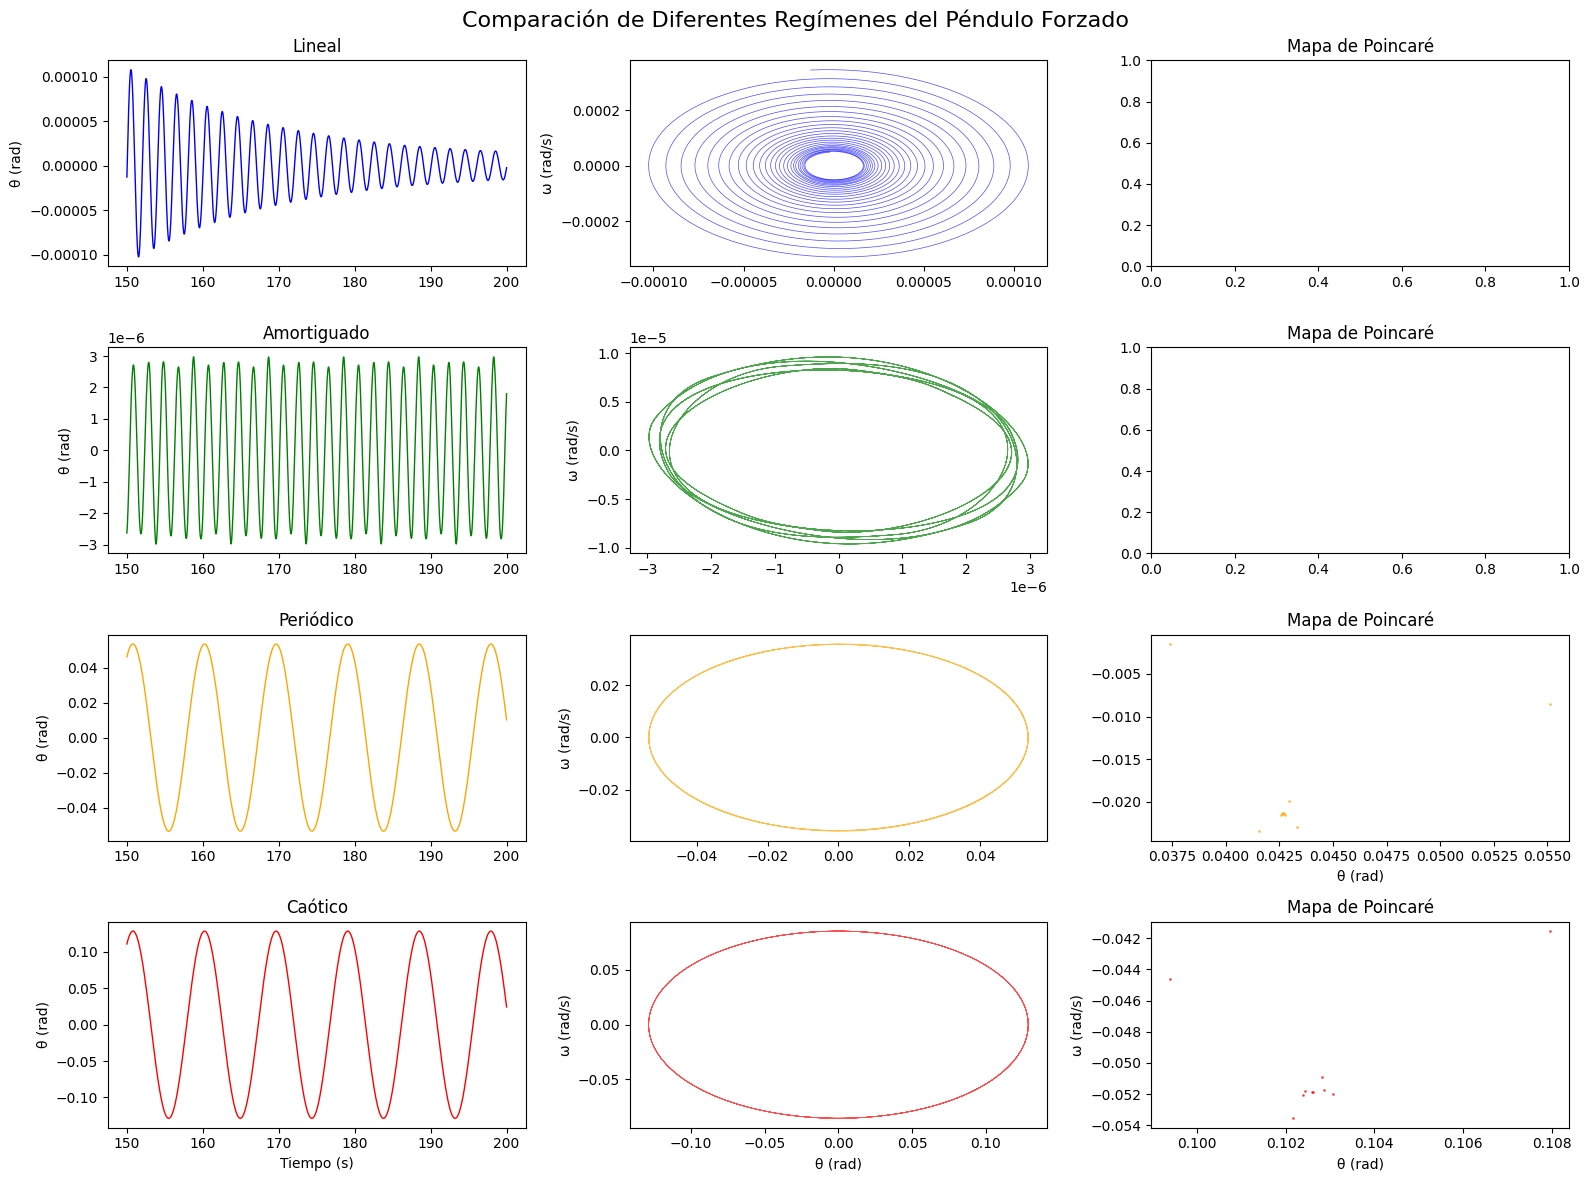


2. Analizando transición al comportamiento caótico...


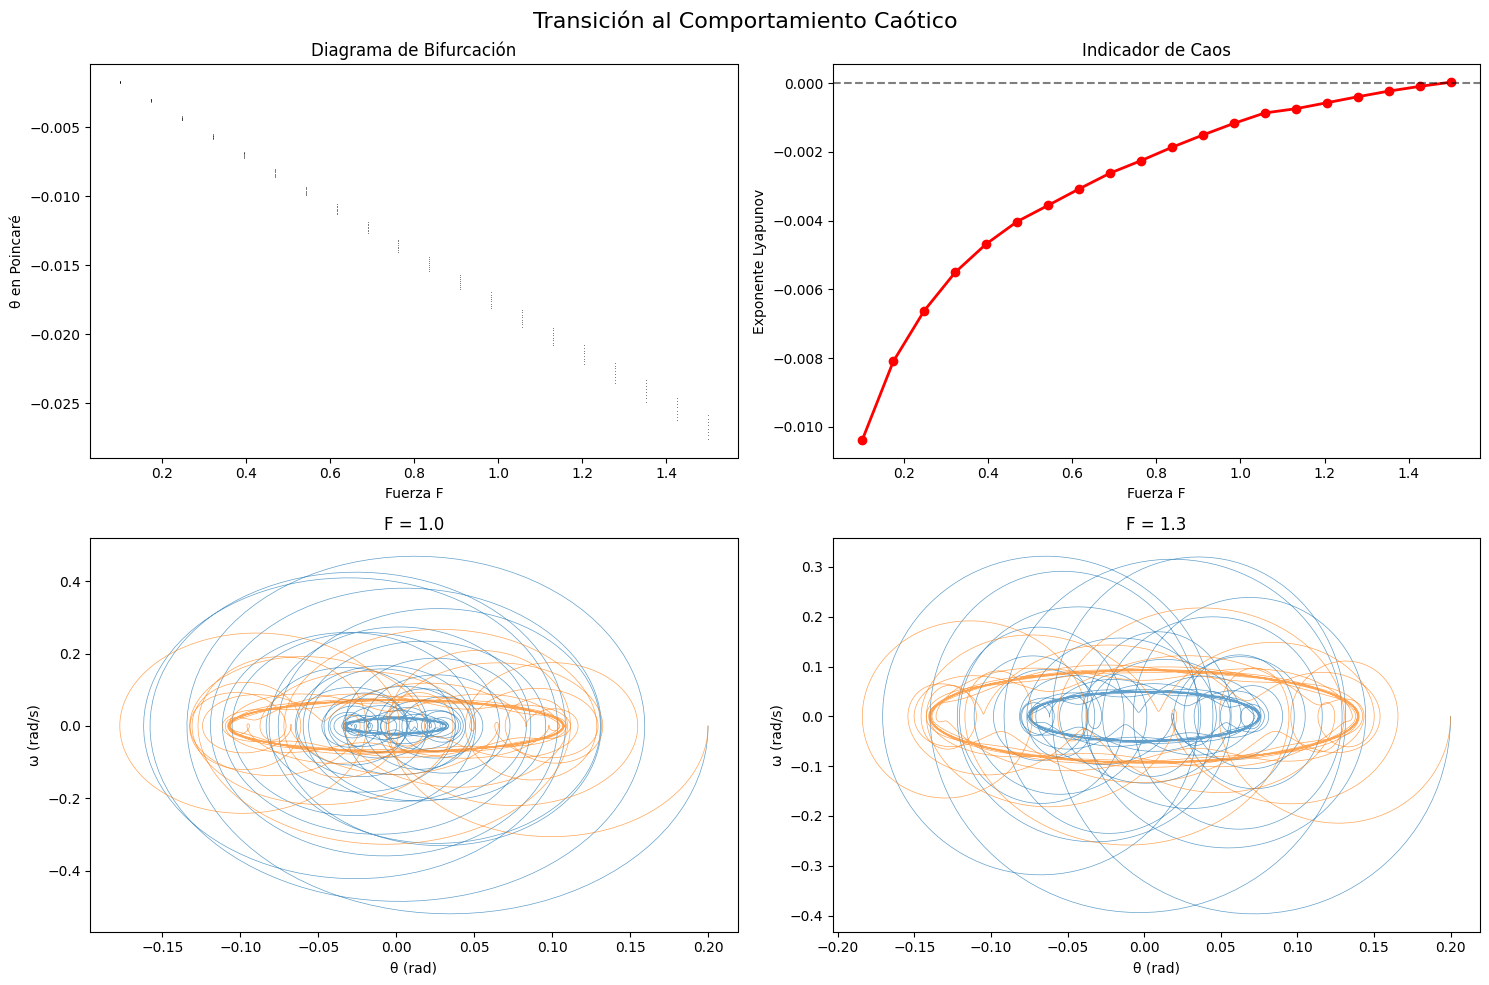


3. Comparando métodos numéricos...


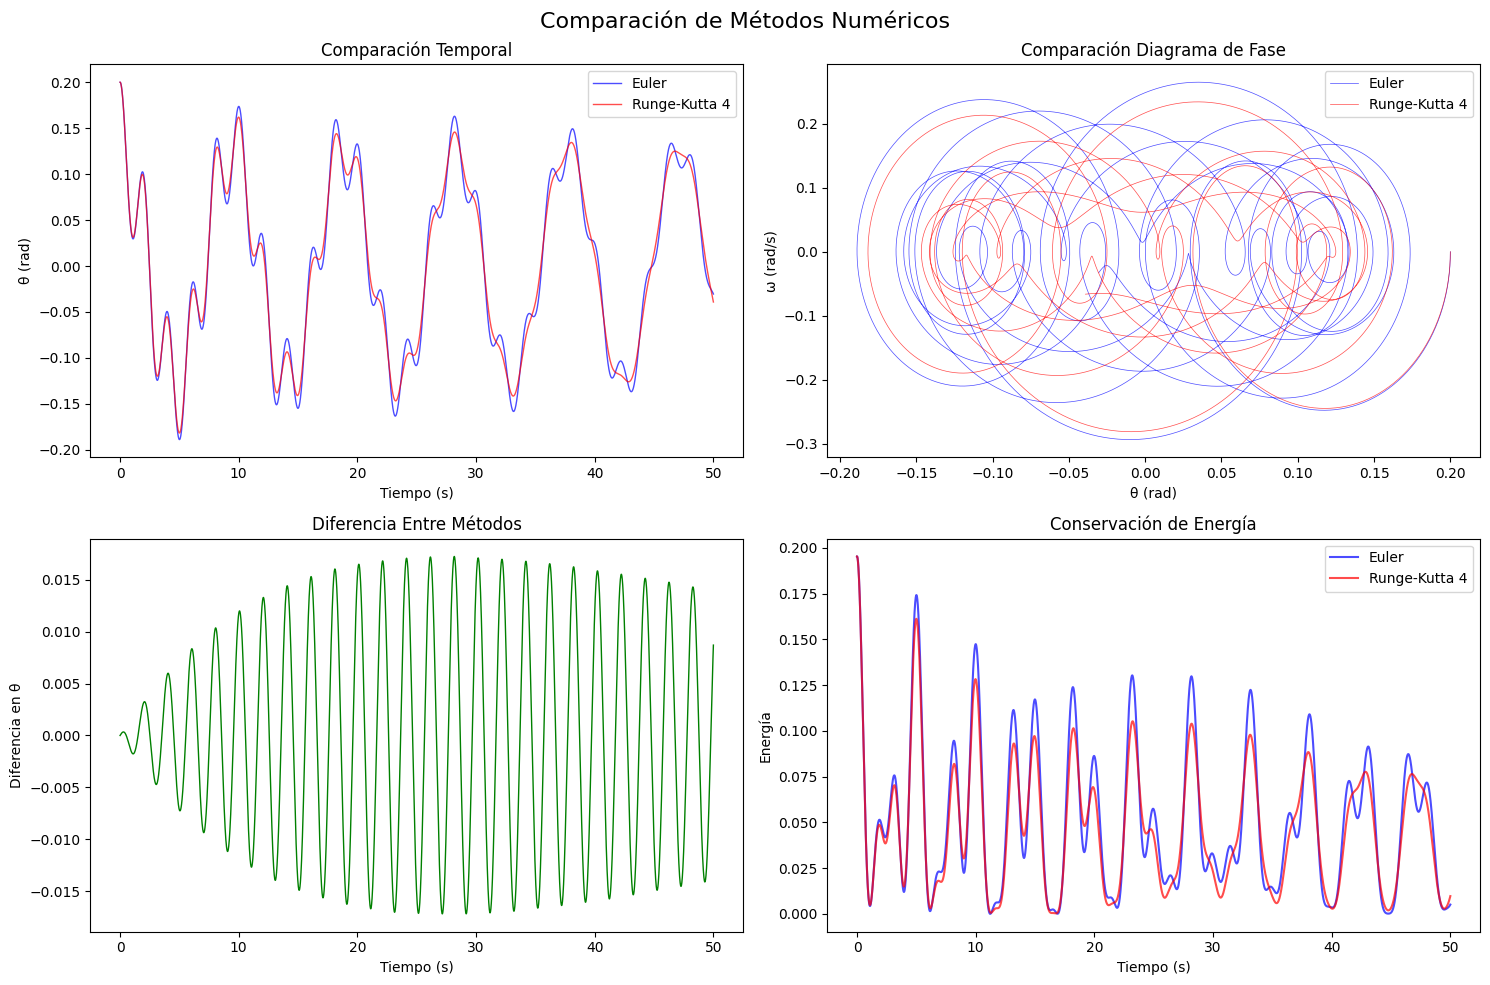


4. Demostrando sensibilidad a condiciones iniciales...


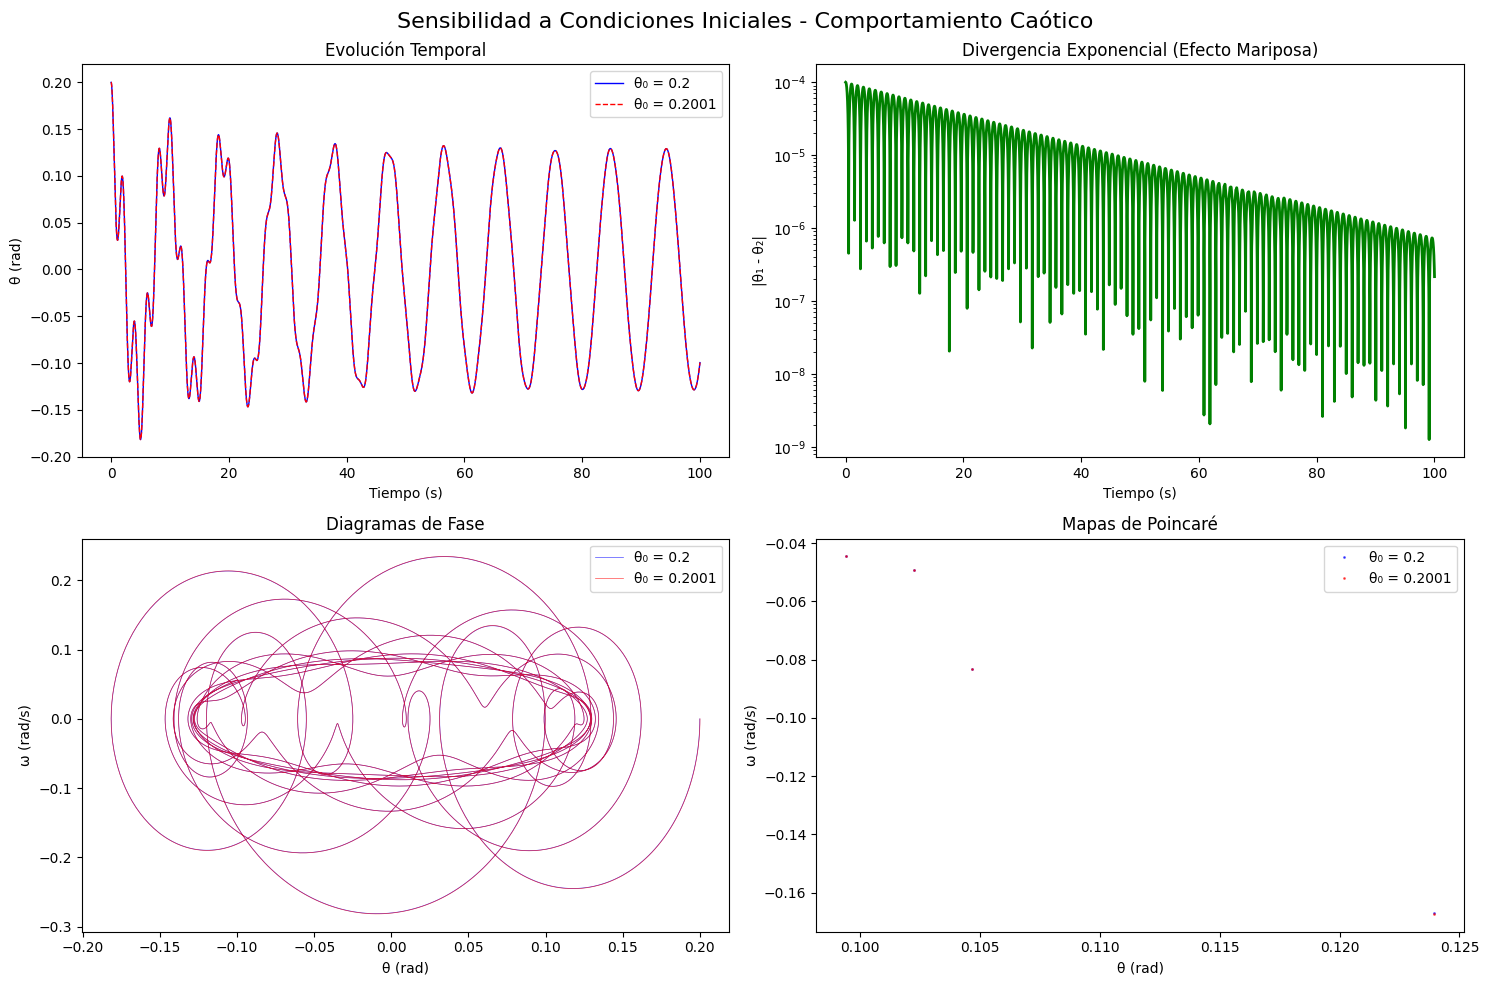


5. Creando animación...

5. Creando animación...


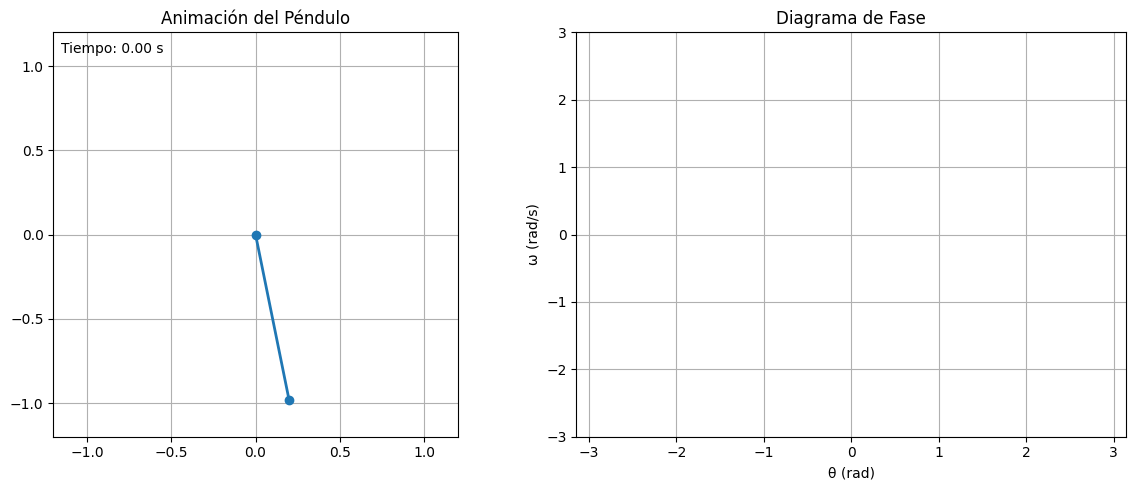


ANÁLISIS COMPLETADO


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from matplotlib import gridspec

import matplotlib
matplotlib.rcParams['animation.html'] = 'jshtml'
matplotlib.rcParams['figure.dpi'] = 100
# =============================================================================
# PARÁMETROS Y CONFIGURACIÓN
# =============================================================================
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (15, 10)

# Parámetros físicos
g = 9.8  # gravedad (m/s²)
L = 1.0  # longitud del péndulo (m)

# Diferentes casos de estudio
cases = {
    'lineal': {'gamma': 0.1, 'F': 0.0, 'omega_d': 2/3, 'color': 'blue', 'label': 'Lineal'},
    'amortiguado': {'gamma': 0.5, 'F': 0.0, 'omega_d': 2/3, 'color': 'green', 'label': 'Amortiguado'},
    'periodico': {'gamma': 0.1, 'F': 0.5, 'omega_d': 2/3, 'color': 'orange', 'label': 'Periódico'},
    'caotico': {'gamma': 0.1, 'F': 1.2, 'omega_d': 2/3, 'color': 'red', 'label': 'Caótico'}
}

# =============================================================================
# DEFINICIÓN DEL SISTEMA Y MÉTODOS NUMÉRICOS
# =============================================================================
def pendulum_system(t, y, gamma, g, L, F, omega_d):
    """
    Sistema del péndulo forzado y amortiguado
    y[0] = theta (ángulo)
    y[1] = omega (velocidad angular)
    """
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -gamma * omega - (g/L) * np.sin(theta) + F * np.cos(omega_d * t)
    return [dtheta_dt, domega_dt]

def euler_method(system, t_span, y0, params, n_points=10000):
    """
    Método de Euler explícito
    """
    t0, tf = t_span
    t = np.linspace(t0, tf, n_points)
    dt = t[1] - t[0]

    y = np.zeros((len(y0), n_points))
    y[:, 0] = y0

    for i in range(1, n_points):
        derivative = system(t[i-1], y[:, i-1], **params)
        y[:, i] = y[:, i-1] + np.array(derivative) * dt

    return t, y

def runge_kutta_4(system, t_span, y0, params, n_points=10000):
    """
    Método de Runge-Kutta de 4to orden
    """
    t0, tf = t_span
    t = np.linspace(t0, tf, n_points)
    dt = t[1] - t[0]

    y = np.zeros((len(y0), n_points))
    y[:, 0] = y0

    for i in range(1, n_points):
        k1 = np.array(system(t[i-1], y[:, i-1], **params))
        k2 = np.array(system(t[i-1] + dt/2, y[:, i-1] + k1*dt/2, **params))
        k3 = np.array(system(t[i-1] + dt/2, y[:, i-1] + k2*dt/2, **params))
        k4 = np.array(system(t[i-1] + dt, y[:, i-1] + k3*dt, **params))

        y[:, i] = y[:, i-1] + (k1 + 2*k2 + 2*k3 + k4) * dt / 6

    return t, y

def solve_pendulum(method='rk4', case_params=None, y0=None, t_span=(0, 100)):
    """
    Resuelve el péndulo con el método especificado
    """
    if y0 is None:
        y0 = [0.2, 0]  # [theta, omega]

    if case_params is None:
        case_params = cases['caotico']

    params = {
        'gamma': case_params['gamma'],
        'g': g,
        'L': L,
        'F': case_params['F'],
        'omega_d': case_params['omega_d']
    }

    if method.lower() == 'euler':
        t, y = euler_method(pendulum_system, t_span, y0, params)
    else:  # RK4 por defecto
        sol = solve_ivp(pendulum_system, t_span, y0, args=tuple(params.values()),
                       method='RK45', dense_output=True, rtol=1e-8)
        t = np.linspace(t_span[0], t_span[1], 10000)
        y = sol.sol(t)

    return t, y, params

# =============================================================================
# ANÁLISIS Y VISUALIZACIÓN
# =============================================================================
def poincare_map(t, y, omega_d, discard_transient=0.1):
    """
    Calcula el mapa de Poincaré
    """
    # Descartar transitorio inicial
    total_points = len(t)
    start_idx = int(total_points * discard_transient)

    # Periodo de la fuerza externa
    T_d = 2 * np.pi / omega_d

    # Muestrear en fase fija (múltiplos del periodo)
    t_poincare = []
    theta_poincare = []
    omega_poincare = []

    for i in range(start_idx, total_points):
        # Verificar si estamos cerca de un múltiplo del periodo
        if abs((t[i] - start_idx) % T_d) < (t[1] - t[0])/2:
            t_poincare.append(t[i])
            theta_poincare.append(y[0, i] if y.ndim > 1 else y[0])
            omega_poincare.append(y[1, i] if y.ndim > 1 else y[1])

    return np.array(theta_poincare), np.array(omega_poincare)

def calculate_lyapunov(theta_trajectory, dt):
    """
    Calcula un estimado simple del exponente de Lyapunov
    """
    if len(theta_trajectory) < 2:
        return 0

    # Usar diferencias consecutivas para estimar divergencia
    differences = np.abs(np.diff(theta_trajectory))
    mask = differences > 1e-10  # Evitar log(0)

    if np.sum(mask) > 10:  # Suficientes puntos válidos
        log_diff = np.log(differences[mask])
        time_points = np.arange(len(log_diff)) * dt
        if len(time_points) > 1:
            # Ajuste lineal para obtener el exponente
            coeffs = np.polyfit(time_points, log_diff, 1)
            return coeffs[0]  # Pendiente = exponente de Lyapunov

    return 0

def plot_comparison_all_cases():
    """
    Compara los cuatro casos principales
    """
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(4, 3, figure=fig)

    for idx, (case_name, case_params) in enumerate(cases.items()):
        # Simular
        t, y, params = solve_pendulum('rk4', case_params, t_span=(0, 200))

        # Evolución temporal (últimos 50 segundos)
        mask = t > 150  # Solo últimos 50 segundos
        ax1 = fig.add_subplot(gs[idx, 0])
        ax1.plot(t[mask], y[0, mask] if y.ndim > 1 else y[0][mask],
                color=case_params['color'], linewidth=1)
        ax1.set_ylabel('θ (rad)')
        ax1.set_title(f'{case_params["label"]}')
        if idx == 3:
            ax1.set_xlabel('Tiempo (s)')

        # Diagrama de fase
        ax2 = fig.add_subplot(gs[idx, 1])
        ax2.plot(y[0, mask] if y.ndim > 1 else y[0][mask],
                y[1, mask] if y.ndim > 1 else y[1][mask],
                color=case_params['color'], linewidth=0.5, alpha=0.7)
        ax2.set_ylabel('ω (rad/s)')
        if idx == 3:
            ax2.set_xlabel('θ (rad)')

        # Mapa de Poincaré (solo para casos con F ≠ 0)
        ax3 = fig.add_subplot(gs[idx, 2])
        if case_params['F'] > 0:
            theta_poincare, omega_poincare = poincare_map(t, y, params['omega_d'])
            ax3.plot(theta_poincare, omega_poincare, '.',
                    color=case_params['color'], markersize=2, alpha=0.6)
            ax3.set_xlabel('θ (rad)')
            if idx == 3:
                ax3.set_ylabel('ω (rad/s)')
        ax3.set_title('Mapa de Poincaré')

    plt.suptitle('Comparación de Diferentes Regímenes del Péndulo Forzado', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_transition_to_chaos():
    """
    Muestra la transición al caos variando F
    """
    F_values = np.linspace(0.1, 1.5, 20)
    gamma = 0.1
    omega_d = 2/3

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Diagrama de bifurcación
    all_F = []
    all_theta = []

    for F in F_values:
        params = {'gamma': gamma, 'F': F, 'omega_d': omega_d, 'g': g, 'L': L}
        t, y, _ = solve_pendulum('rk4', params, t_span=(0, 500))

        # Mapa de Poincaré después del transitorio
        theta_poincare, omega_poincare = poincare_map(t, y, omega_d, discard_transient=0.7)

        # Almacenar para el diagrama de bifurcación
        all_F.extend([F] * len(theta_poincare))
        all_theta.extend(theta_poincare)

    # Diagrama de bifurcación
    axes[0,0].plot(all_F, all_theta, ',k', alpha=0.5, markersize=1)
    axes[0,0].set_xlabel('Fuerza F')
    axes[0,0].set_ylabel('θ en Poincaré')
    axes[0,0].set_title('Diagrama de Bifurcación')

    # Exponente de Lyapunov vs F
    lyapunov_exponents = []
    for F in F_values:
        params = {'gamma': gamma, 'F': F, 'omega_d': omega_d, 'g': g, 'L': L}
        t, y, _ = solve_pendulum('rk4', params, t_span=(0, 300))
        dt = t[1] - t[0]
        lyap = calculate_lyapunov(y[0] if y.ndim > 1 else y[0], dt)
        lyapunov_exponents.append(lyap)

    axes[0,1].plot(F_values, lyapunov_exponents, 'ro-', linewidth=2)
    axes[0,1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[0,1].set_xlabel('Fuerza F')
    axes[0,1].set_ylabel('Exponente Lyapunov')
    axes[0,1].set_title('Indicador de Caos')

    # Ejemplos específicos
    example_F = [0.3, 0.7, 1.0, 1.3]
    for i, F in enumerate(example_F):
        params = {'gamma': gamma, 'F': F, 'omega_d': omega_d, 'g': g, 'L': L}
        t, y, _ = solve_pendulum('rk4', params, t_span=(0, 200))

        # Diagrama de fase
        row, col = 1, i % 2
        axes[row, col].plot(y[0] if y.ndim > 1 else y[0],
                          y[1] if y.ndim > 1 else y[1],
                          linewidth=0.5, alpha=0.7)
        axes[row, col].set_xlabel('θ (rad)')
        axes[row, col].set_ylabel('ω (rad/s)')
        axes[row, col].set_title(f'F = {F}')

    plt.suptitle('Transición al Comportamiento Caótico', fontsize=16)
    plt.tight_layout()
    plt.show()

def compare_numerical_methods():
    """
    Compara Euler vs Runge-Kutta
    """
    params = cases['caotico']
    y0 = [0.2, 0]
    t_span = (0, 50)

    # Resolver con ambos métodos
    t_euler, y_euler, _ = solve_pendulum('euler', params, y0, t_span)
    t_rk4, y_rk4, _ = solve_pendulum('rk4', params, y0, t_span)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Evolución temporal
    axes[0,0].plot(t_euler, y_euler[0], 'b-', label='Euler', linewidth=1, alpha=0.7)
    axes[0,0].plot(t_rk4, y_rk4[0], 'r-', label='Runge-Kutta 4', linewidth=1, alpha=0.7)
    axes[0,0].set_xlabel('Tiempo (s)')
    axes[0,0].set_ylabel('θ (rad)')
    axes[0,0].set_title('Comparación Temporal')
    axes[0,0].legend()

    # Diagrama de fase
    axes[0,1].plot(y_euler[0], y_euler[1], 'b-', label='Euler', linewidth=0.5, alpha=0.7)
    axes[0,1].plot(y_rk4[0], y_rk4[1], 'r-', label='Runge-Kutta 4', linewidth=0.5, alpha=0.7)
    axes[0,1].set_xlabel('θ (rad)')
    axes[0,1].set_ylabel('ω (rad/s)')
    axes[0,1].set_title('Comparación Diagrama de Fase')
    axes[0,1].legend()

    # Diferencia entre métodos
    time_common = min(len(t_euler), len(t_rk4))
    theta_diff = y_euler[0, :time_common] - y_rk4[0, :time_common]

    axes[1,0].plot(t_euler[:time_common], theta_diff, 'g-', linewidth=1)
    axes[1,0].set_xlabel('Tiempo (s)')
    axes[1,0].set_ylabel('Diferencia en θ')
    axes[1,0].set_title('Diferencia Entre Métodos')

    # Energía (para ver conservación)
    energy_euler = 0.5 * L**2 * y_euler[1]**2 + g * L * (1 - np.cos(y_euler[0]))
    energy_rk4 = 0.5 * L**2 * y_rk4[1]**2 + g * L * (1 - np.cos(y_rk4[0]))

    axes[1,1].plot(t_euler, energy_euler, 'b-', label='Euler', alpha=0.7)
    axes[1,1].plot(t_rk4, energy_rk4, 'r-', label='Runge-Kutta 4', alpha=0.7)
    axes[1,1].set_xlabel('Tiempo (s)')
    axes[1,1].set_ylabel('Energía')
    axes[1,1].set_title('Conservación de Energía')
    axes[1,1].legend()

    plt.suptitle('Comparación de Métodos Numéricos', fontsize=16)
    plt.tight_layout()
    plt.show()

def sensitivity_to_initial_conditions():
    """
    Demuestra sensibilidad a condiciones iniciales (efecto mariposa)
    """
    params = cases['caotico']

    # Dos condiciones iniciales muy cercanas
    y01 = [0.2, 0]
    y02 = [0.2001, 0]  # Diferencia de 0.0001 rad

    t_span = (0, 100)

    t1, y1, _ = solve_pendulum('rk4', params, y01, t_span)
    t2, y2, _ = solve_pendulum('rk4', params, y02, t_span)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Evolución temporal
    axes[0,0].plot(t1, y1[0], 'b-', label='θ₀ = 0.2', linewidth=1)
    axes[0,0].plot(t2, y2[0], 'r--', label='θ₀ = 0.2001', linewidth=1)
    axes[0,0].set_xlabel('Tiempo (s)')
    axes[0,0].set_ylabel('θ (rad)')
    axes[0,0].set_title('Evolución Temporal')
    axes[0,0].legend()

    # Diferencia entre trayectorias
    time_common = min(len(t1), len(t2))
    theta_diff = np.abs(y1[0, :time_common] - y2[0, :time_common])

    axes[0,1].semilogy(t1[:time_common], theta_diff, 'g-', linewidth=2)
    axes[0,1].set_xlabel('Tiempo (s)')
    axes[0,1].set_ylabel('|θ₁ - θ₂|')
    axes[0,1].set_title('Divergencia Exponencial (Efecto Mariposa)')

    # Diagramas de fase superpuestos
    axes[1,0].plot(y1[0], y1[1], 'b-', label='θ₀ = 0.2', linewidth=0.5, alpha=0.7)
    axes[1,0].plot(y2[0], y2[1], 'r-', label='θ₀ = 0.2001', linewidth=0.5, alpha=0.7)
    axes[1,0].set_xlabel('θ (rad)')
    axes[1,0].set_ylabel('ω (rad/s)')
    axes[1,0].set_title('Diagramas de Fase')
    axes[1,0].legend()

    # Mapas de Poincaré
    theta_p1, omega_p1 = poincare_map(t1, y1, params['omega_d'])
    theta_p2, omega_p2 = poincare_map(t2, y2, params['omega_d'])

    axes[1,1].plot(theta_p1, omega_p1, 'b.', label='θ₀ = 0.2', markersize=2, alpha=0.6)
    axes[1,1].plot(theta_p2, omega_p2, 'r.', label='θ₀ = 0.2001', markersize=2, alpha=0.6)
    axes[1,1].set_xlabel('θ (rad)')
    axes[1,1].set_ylabel('ω (rad/s)')
    axes[1,1].set_title('Mapas de Poincaré')
    axes[1,1].legend()

    plt.suptitle('Sensibilidad a Condiciones Iniciales - Comportamiento Caótico', fontsize=16)
    plt.tight_layout()
    plt.show()

# =============================================================================
# ANIMACIÓN
# =============================================================================
def create_animation():
    """
    Crea una animación del péndulo caótico
    """
    params = cases['caotico']
    t, y, _ = solve_pendulum('rk4', params, t_span=(0, 30))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Configurar subplot de animación
    ax1.set_xlim(-1.2*L, 1.2*L)
    ax1.set_ylim(-1.2*L, 1.2*L)
    ax1.set_aspect('equal')
    ax1.set_title('Animación del Péndulo')
    ax1.grid(True)

    # Configurar subplot de trayectoria
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_ylim(-3, 3)
    ax2.set_xlabel('θ (rad)')
    ax2.set_ylabel('ω (rad/s)')
    ax2.set_title('Diagrama de Fase')
    ax2.grid(True)

    # Elementos de la animación
    line, = ax1.plot([], [], 'o-', lw=2)
    trail, = ax1.plot([], [], 'g-', lw=1, alpha=0.5)
    phase_line, = ax2.plot([], [], 'b-', lw=1, alpha=0.7)
    time_text = ax1.text(0.02, 0.95, '', transform=ax1.transAxes)

    # Datos para la trayectoria
    x_trail, y_trail = [], []
    theta_phase, omega_phase = [], []

    def animate(i):
        # Actualizar péndulo
        theta = y[0, i] if y.ndim > 1 else y[0][i]
        x = L * np.sin(theta)
        y_pos = -L * np.cos(theta)

        line.set_data([0, x], [0, y_pos])

        # Actualizar estela
        x_trail.append(x)
        y_trail.append(y_pos)
        if len(x_trail) > 100:  # Mantener solo últimos 100 puntos
            x_trail.pop(0)
            y_trail.pop(0)
        trail.set_data(x_trail, y_trail)

        # Actualizar diagrama de fase
        theta_phase.append(theta)
        omega_phase.append(y[1, i] if y.ndim > 1 else y[1][i])
        if len(theta_phase) > 500:
            theta_phase.pop(0)
            omega_phase.pop(0)
        phase_line.set_data(theta_phase, omega_phase)

        time_text.set_text(f'Tiempo: {t[i]:.2f} s')

        return line, trail, phase_line, time_text

    # Crear animación
    frames = min(500, len(t))
    anim = animation.FuncAnimation(fig, animate, frames=frames,
                                 interval=20, blit=True)

    plt.tight_layout()
    plt.show()

    return anim

# =============================================================================
# EJECUCIÓN PRINCIPAL
# =============================================================================
def main():
    """
    Función principal que ejecuta todos los análisis
    """
    print("=" * 60)
    print("PROYECTO: PÉNDULO AMORTIGUADO Y FORZADO - ANÁLISIS DE CAOS")
    print("=" * 60)

    # 1. Comparación de todos los casos
    print("\n1. Comparando diferentes regímenes...")
    plot_comparison_all_cases()

    # 2. Transición al caos
    print("\n2. Analizando transición al comportamiento caótico...")
    plot_transition_to_chaos()

    # 3. Comparación de métodos numéricos
    print("\n3. Comparando métodos numéricos...")
    compare_numerical_methods()

    # 4. Sensibilidad a condiciones iniciales
    print("\n4. Demostrando sensibilidad a condiciones iniciales...")
    sensitivity_to_initial_conditions()

    # 5. Animación
    print("\n5. Creando animación...")
    print("\n5. Creando animación...")
    create_animation()

    print("\n" + "=" * 60)
    print("ANÁLISIS COMPLETADO")
    print("=" * 60)

# Ejecutar el programa principal
if __name__ == "__main__":
    main()